In [1]:
import keras

Using Theano backend.


In [2]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import cv2, numpy as np

def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def get_image(path):
    im = cv2.resize(cv2.imread(path), (224, 224)).astype(np.float32)
    im[:,:,0] -= 103.939
    im[:,:,1] -= 116.779
    im[:,:,2] -= 123.68
    im = im.transpose((2,0,1))
    return im

def draw_image(path, title=""):
    im = cv2.resize(cv2.imread(path), (224, 224))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.title(path + " " + str(title))

In [4]:
from keras import backend as K
def get_layer(model, layer, X_batch):
    return K.function([model.layers[0].input], [model.layers[layer].output])([X_batch])[0]

In [5]:
# Test pretrained model
model = VGG_16('vgg16_weights.h5')
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

In [6]:
import os
from scipy.spatial.distance import cosine
class ImageBase:
    def __init__(self, dataPath, model, layer=30):        
        allFiles = list(map(lambda x: dataPath + x, os.listdir(dataPath)))
        features = None
        for i, file in enumerate(allFiles):
            if i == 0:
                x = get_layer(model, layer, [get_image(file)])[0].reshape(-1)
                features = np.zeros((len(allFiles), x.shape[0]))
            features[i] =  get_layer(model, layer, [get_image(file)])[0].reshape(-1)
        self._pathImages = allFiles
        self._features = features
        self._layer = layer
    def showSimilar(self, path, top=10):
        plt.figure(0)
        draw_image(path)
        
        x = get_layer(model, self._layer, [get_image(path)])[0].reshape(-1)
        sim = [cosine(x, y) for y in self._features]
        top_imgs = np.argsort(sim)[:top]
        for i, img in enumerate(top_imgs):
            plt.figure(i + 1)    
            draw_image(self._pathImages[img])
        

Берем достаточно глубокий уровень, и видим что похожесть определяется высокоуровневыми признаками, такими как форма, модель.

In [7]:
imageBase = ImageBase(dataPath='./shmot_small/', model=model, layer=31)

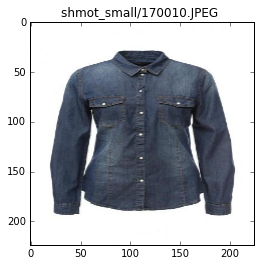

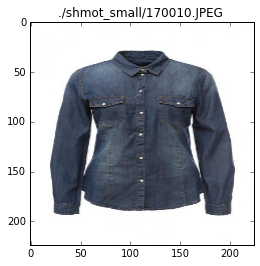

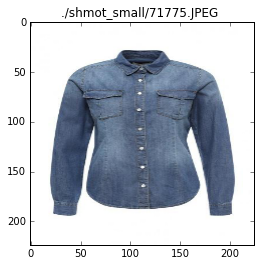

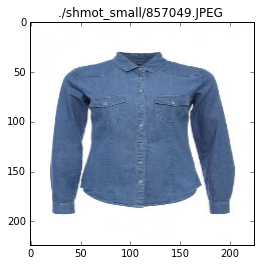

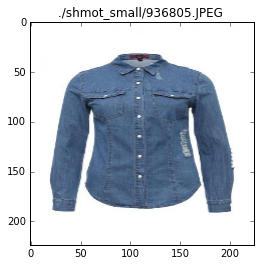

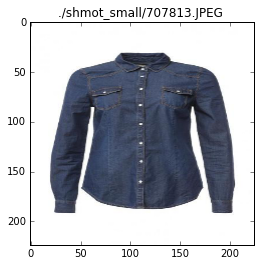

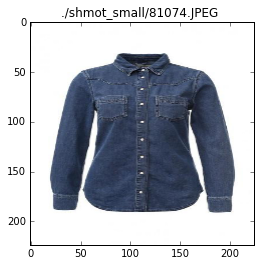

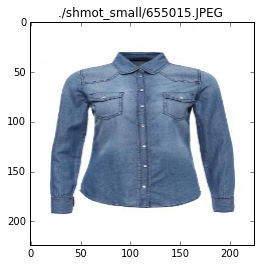

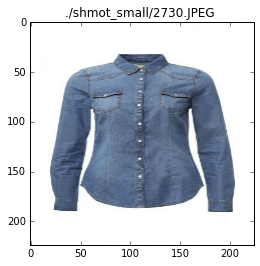

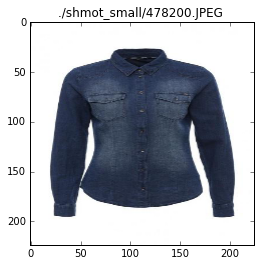

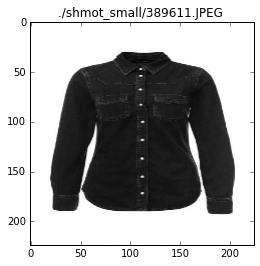

In [13]:
imageBase.showSimilar('shmot_small/170010.JPEG')

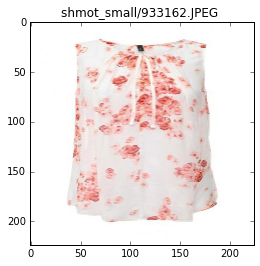

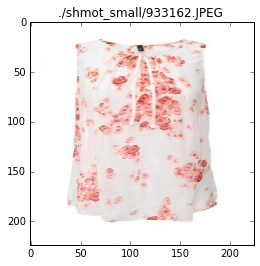

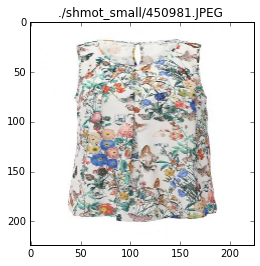

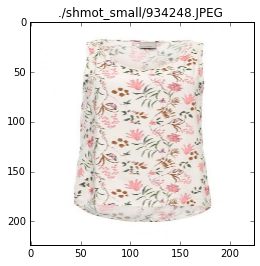

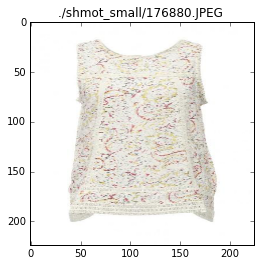

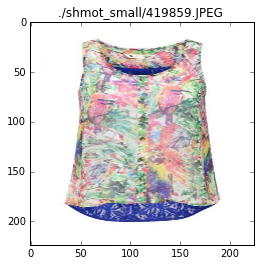

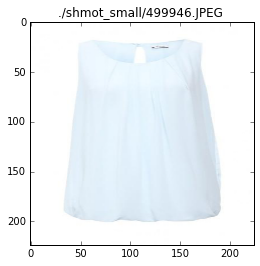

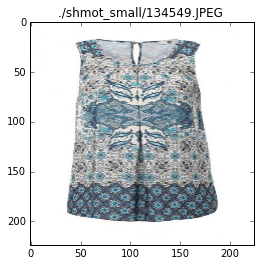

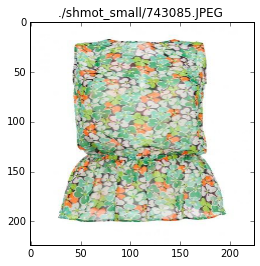

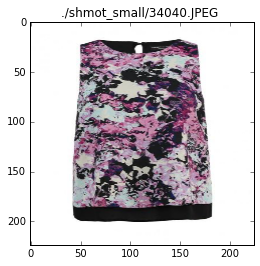

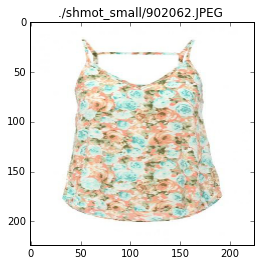

In [12]:
imageBase.showSimilar('shmot_small/933162.JPEG')

Берем неглубокий сверточный , и видим что похожесть определяется низкоуровневыми признаками, такими как текстура, цвет

In [7]:
imageBase2 = ImageBase(dataPath='./shmot_small/', model=model, layer=8)

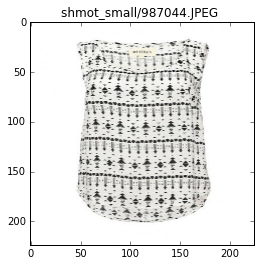

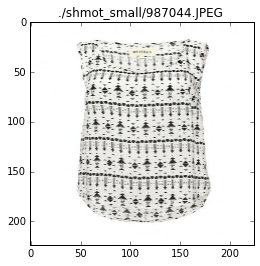

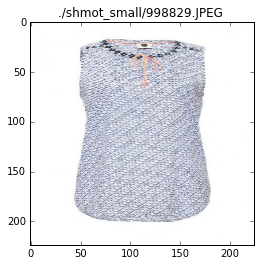

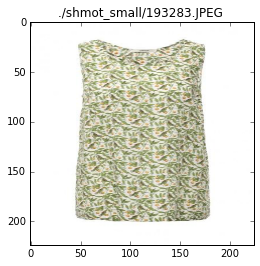

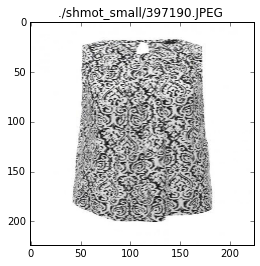

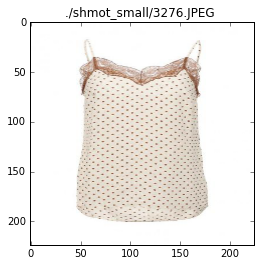

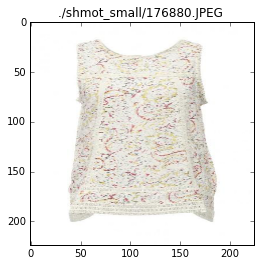

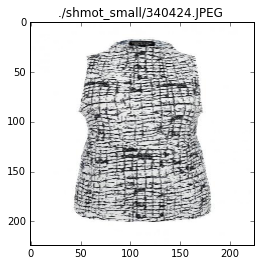

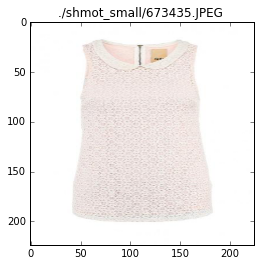

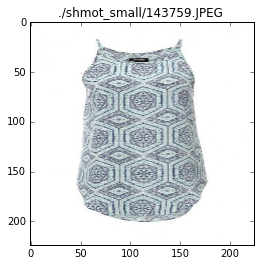

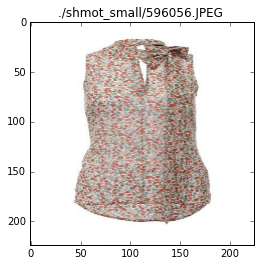

In [8]:
imageBase2.showSimilar('shmot_small/987044.JPEG')

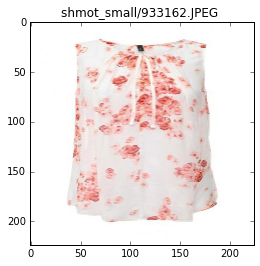

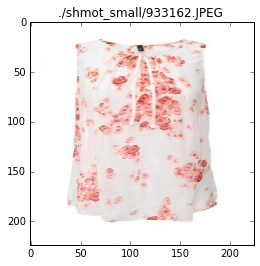

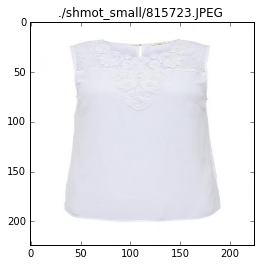

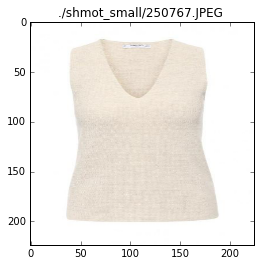

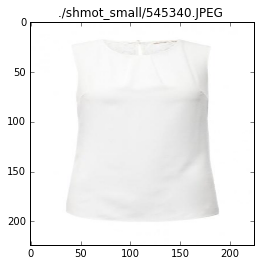

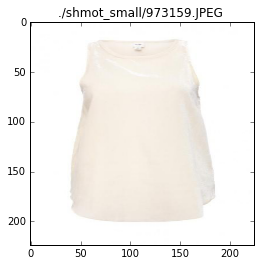

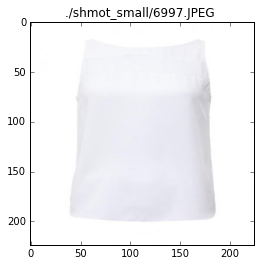

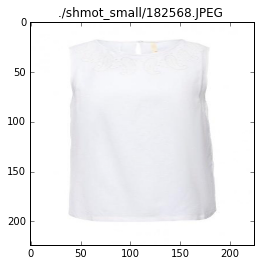

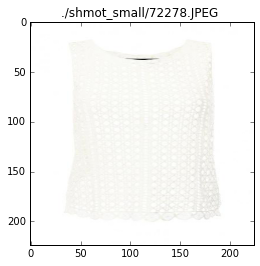

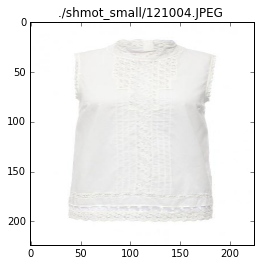

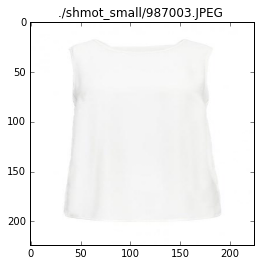

In [9]:
imageBase2.showSimilar('shmot_small/933162.JPEG')